In [56]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np
import time
from math import exp

In [2]:
hr = pd.read_csv('/Users/sharad/Courses/DATA_5600/Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
hr.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
hr.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [4]:
hr.shape

(1470, 35)

In [5]:
Counter(hr['Attrition'])

Counter({'Yes': 237, 'No': 1233})

In [6]:
1233/(1233+237)

0.8387755102040816

In [7]:
hr['Attrition'] = np.where(hr['Attrition']=='Yes',1,0)
hr['OverTime'] = np.where(hr['OverTime']=='Yes',1,0)

## Train-Test Split

In [8]:
def train_test_split(df, frac=0.2):
    test = df.sample(frac=frac, axis=0)
    train = df.drop(index=test.index)

    return train, test

In [9]:
hr_train, hr_test = train_test_split(hr)
print(hr_train.shape)
print(hr_test.shape)

(1176, 35)
(294, 35)


## Train-Val-Test Split

In [10]:
splits = np.random.choice(a = 3, size = hr.shape[0], p = [0.7,0.15,0.15])

In [11]:
print(splits)
print(Counter(splits))

[0 2 2 ... 0 0 0]
Counter({0: 1037, 2: 241, 1: 192})


In [33]:
hr_train = hr.iloc[np.where(splits == 0)[0],:]
hr_val = hr.iloc[np.where(splits == 1)[0],:]
hr_test = hr.iloc[np.where(splits == 2)[0],:]

print(hr_train.shape)
print(hr_val.shape)
print(hr_test.shape)

(1037, 35)
(192, 35)
(241, 35)


In [34]:
thresholds = np.linspace(0,1,100)

Xtrain = hr_train[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
ytrain = hr_train[['Attrition']]
Xtrain = sm.add_constant(Xtrain)
log_reg = sm.Logit(ytrain, Xtrain).fit()

Xval = hr_val[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
Xval = pd.get_dummies(data=Xval, drop_first=True)
yval = hr_val[['Attrition']]
Xval = sm.add_constant(Xval)
val_preds = log_reg.predict(Xval)

acc_list = []
for thresh in thresholds:
    binary_preds = np.where(val_preds >= thresh, 1, 0)
    acc_list.append(accuracy_score(yval, binary_preds))
    

Optimization terminated successfully.
         Current function value: 0.382128
         Iterations 7


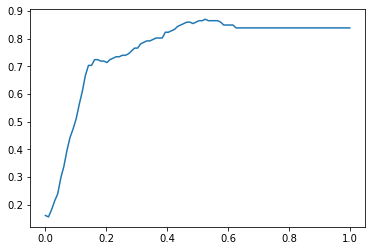

In [35]:
plt.plot(thresholds, acc_list)

In [36]:
thresholds[np.argmax(acc_list)]

0.5252525252525253

In [37]:
binary_preds = np.where(val_preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(yval, binary_preds)

0.8697916666666666

In [38]:
Xtest = hr_test[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
Xtest = pd.get_dummies(data=Xtest, drop_first=True)
ytest = hr_test[['Attrition']]
Xtest = sm.add_constant(Xtest)
preds = log_reg.predict(Xtest)

In [39]:
# Accuracy if we had gone with a "gut feeling" guess for the threshold of 0.8
binary_preds = np.where(preds >= 0.8, 1, 0)

accuracy_score(ytest, binary_preds)

0.8381742738589212

In [40]:
# Accuracy by going with the "optimal" threshold
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(ytest, binary_preds)

0.8672199170124482

## LOOCV

In [44]:
hr_train_val = pd.concat([hr_train, hr_val])
hr_train_val.reset_index(inplace=True, drop=True)

In [47]:
bin_pred_list = []
for i in range(len(hr_train_val)):
    val = hr_train_val.iloc[i,:].to_frame().T
    train = hr_train_val.drop(index=i)
    
    Xtrain = train[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
    ytrain = train[['Attrition']]
    Xtrain = sm.add_constant(Xtrain)
    log_reg = sm.Logit(ytrain, Xtrain).fit()

    Xval = val[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
    yval = val[['Attrition']]
    Xval = sm.add_constant(Xval, has_constant='add')
    val_preds = log_reg.predict(Xval.apply(pd.to_numeric))
    
    binary_preds = np.where(val_preds >= thresholds[np.argmax(acc_list)], 1, 0)
    bin_pred_list.append(binary_preds[0])

Optimization terminated successfully.
         Current function value: 0.387276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388191
  

In [48]:
accuracy_score(hr_train_val['Attrition'], bin_pred_list)

0.855166802278275

This gives us a better estimate of the expected performance on the test set, using the threshold value we found above. But what if we want to use LOOCV to select the threshold value as well.

In [57]:
thresholds = np.linspace(0,1,10)
acc_list = []

t0 = time.time()
for thresh in thresholds:
    bin_pred_list = []
    for i in range(len(hr_train_val)):
        val = hr_train_val.iloc[i,:].to_frame().T
        train = hr_train_val.drop(index=i)

        Xtrain = train[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
        ytrain = train[['Attrition']]
        Xtrain = sm.add_constant(Xtrain)
        log_reg = sm.Logit(ytrain, Xtrain).fit()

        Xval = val[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
        yval = val[['Attrition']]
        Xval = sm.add_constant(Xval, has_constant='add')
        val_preds = log_reg.predict(Xval.apply(pd.to_numeric))

        binary_preds = np.where(val_preds >= thresh, 1, 0)
        bin_pred_list.append(binary_preds[0])
    acc_list.append(accuracy_score(hr_train_val['Attrition'], bin_pred_list))
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.387276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388278
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388191
  

In [58]:
t1-t0

117.30954384803772

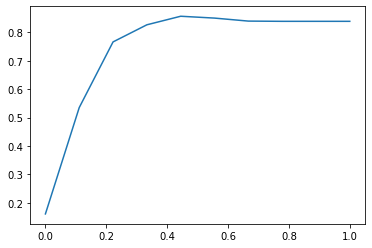

In [50]:
plt.plot(thresholds, acc_list)

In [52]:
Xtest = hr_test[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
Xtest = pd.get_dummies(data=Xtest, drop_first=True)
ytest = hr_test[['Attrition']]
Xtest = sm.add_constant(Xtest)
preds = log_reg.predict(Xtest)

In [53]:
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(ytest, binary_preds)

0.8796680497925311

In [54]:
thresholds[np.argmax(acc_list)]

0.4444444444444444

## 10-fold CV

In [79]:
thresholds = np.linspace(0,1,10)
acc_list = []

folds = np.random.choice(a = 10, size = hr_train_val.shape[0])

t0 = time.time()
for thresh in thresholds:
    bin_pred_list = []
    yval_list = []
    for i in range(10):
        val = hr_train_val.iloc[np.where(folds == i)[0],:]
        train = hr_train_val.iloc[np.where(folds != i)[0],:]

        Xtrain = train[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
        ytrain = train[['Attrition']]
        Xtrain = sm.add_constant(Xtrain)
        log_reg = sm.Logit(ytrain, Xtrain).fit()

        Xval = val[['Age', 'DistanceFromHome', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'JobLevel']]
        yval = val[['Attrition']]
        Xval = sm.add_constant(Xval, has_constant='add')
        val_preds = log_reg.predict(Xval.apply(pd.to_numeric))
    
        binary_preds = np.where(val_preds >= thresh, 1, 0)
        bin_pred_list.extend(binary_preds)
        yval_list.extend(yval['Attrition'].tolist())
    acc_list.append(accuracy_score(yval_list, bin_pred_list))
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.388001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382207
  

In [80]:
t1-t0

0.8814890384674072

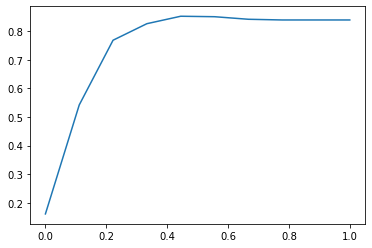

In [81]:
plt.plot(thresholds, acc_list)

In [82]:
print(thresholds[np.argmax(acc_list)])
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(ytest, binary_preds)

0.4444444444444444


0.8796680497925311

## Bootstrap

In [83]:
b0_list = []
b1_list = []

for i in range(11):
    boot_hr = hr_train_val.sample(n=hr_train_val.shape[0], axis=0, replace=True)
    Xtrain = boot_hr[['OverTime']]
    ytrain = boot_hr[['Attrition']]

    Xtrain = sm.add_constant(Xtrain)
    
    log_reg = sm.Logit(ytrain, Xtrain).fit()
    
    b_0 = log_reg.params.values[0]
    b_1 = log_reg.params.values[1]
    
    b0_list.append(b_0)
    b1_list.append(b_1)

Optimization terminated successfully.
         Current function value: 0.428087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432617
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.441567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428986
  

In [84]:
b0_list

[-2.038568979538018,
 -2.117679555434167,
 -2.1590661017411747,
 -2.0331482577089917,
 -2.05056320094115,
 -2.052379619636879,
 -2.011782893206022,
 -2.0110494512262767,
 -2.0219975359487554,
 -2.0105321113043666,
 -2.2236911505243806]

In [85]:
b1_list

[1.226560596101344,
 1.3871059693551047,
 1.2977230666509236,
 1.2064696845245237,
 1.3133560305871745,
 1.1873821821502746,
 1.2716787295583063,
 1.3436547667687464,
 1.0424849388217756,
 1.1793991877705183,
 1.34234744872746]

In [94]:
se_b0 = np.sqrt((1/(len(b0_list)-1))*np.sum(np.square(b0_list-((1/len(b0_list))*np.sum(b0_list)))))

se_b1 = np.sqrt((1/(len(b1_list)-1))*np.sum(np.square(b1_list-((1/len(b1_list))*np.sum(b1_list)))))

In [97]:
print('Mean of B0: ' + str(np.mean(b0_list)))
print('SE of B0: ' + str(se_b0))

Mean of B0: -2.0664053506554714
SE of B0: 0.07030237241823137


In [98]:
print('Mean of B1: ' + str(np.mean(b1_list)))
print('SE of B1: ' + str(se_b1))

Mean of B1: 1.2543784182741957
SE of B1: 0.09851910621752451


In [100]:
Xtrain = hr_train_val[['OverTime']]
Xtrain = pd.get_dummies(data=Xtrain, drop_first=True)
ytrain = hr_train_val[['Attrition']]
Xtrain = sm.add_constant(Xtrain)
log_reg = sm.Logit(ytrain, Xtrain).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.419944
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 1229
Model:                          Logit   Df Residuals:                     1227
Method:                           MLE   Df Model:                            1
Date:                Tue, 24 May 2022   Pseudo R-squ.:                 0.04882
Time:                        15:18:15   Log-Likelihood:                -516.11
converged:                       True   LL-Null:                       -542.60
Covariance Type:            nonrobust   LLR p-value:                 3.362e-13
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0744      0.107    -19.454      0.000      -2.283      -1.865
OverTime       1.1764      0.160      7.355      0.000       0.863       1.490
==============================================================================
"""